In [197]:
import pickle as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import os, sys
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix,accuracy_score,cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy.special import boxcox1p
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

%matplotlib inline

# Find and load the dataset
for dirname, _, filenames in os.walk('C:/Users/AVCI/Desktop/CODE/Github/Customer-Abandonment-Analysis'):
    for filename in filenames:
        if filename == "Customer-Abandonment-Analysis-Data.csv":
            data_path = os.path.join(dirname, filename)

dataset = pd.read_csv(data_path)
dataset.head()

,ID,Is_Product_Details_viewed,Session_Activity_Count,No_Items_Added_InCart,No_Items_Removed_FromCart,No_Cart_Viewed,No_Checkout_Confirmed,No_Checkout_Initiated,No_Cart_Items_Viewed,No_Customer_Login,No_Page_Viewed,Customer_Segment_Type,Cart_Abandoned
0,Session_ID_0,Yes,4,1.0,0,0.0,0,0,1,0,0,0,1
1,Session_ID_1,No,38,0.0,0,2.0,0,0,2,0,2,0,1
2,Session_ID_2,No,8,5.0,0,0.0,1,1,1,0,0,1,0
3,Session_ID_3,No,6,0.0,0,2.0,0,0,4,0,0,0,1
4,Session_ID_4,Yes,31,14.0,12,1.0,0,0,4,0,0,2,1


In [198]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4284 entries, 0 to 4283
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         4284 non-null   object 
 1   Is_Product_Details_viewed  4284 non-null   object 
 2   Session_Activity_Count     4284 non-null   int64  
 3   No_Items_Added_InCart      4275 non-null   float64
 4   No_Items_Removed_FromCart  4284 non-null   int64  
 5   No_Cart_Viewed             4275 non-null   float64
 6   No_Checkout_Confirmed      4284 non-null   int64  
 7   No_Checkout_Initiated      4284 non-null   int64  
 8   No_Cart_Items_Viewed       4284 non-null   int64  
 9   No_Customer_Login          4284 non-null   int64  
 10  No_Page_Viewed             4284 non-null   int64  
 11  Customer_Segment_Type      4284 non-null   int64  
 12  Cart_Abandoned             4284 non-null   int64  
dtypes: float64(2), int64(9), object(2)
memory usage:

In [199]:
dataset.Cart_Abandoned=pd.Categorical(dataset.Cart_Abandoned)
dataset.Customer_Segment_Type=pd.Categorical(dataset.Customer_Segment_Type)
dataset.dtypes

ID                             object
Is_Product_Details_viewed      object
Session_Activity_Count          int64
No_Items_Added_InCart         float64
No_Items_Removed_FromCart       int64
No_Cart_Viewed                float64
No_Checkout_Confirmed           int64
No_Checkout_Initiated           int64
No_Cart_Items_Viewed            int64
No_Customer_Login               int64
No_Page_Viewed                  int64
Customer_Segment_Type        category
Cart_Abandoned               category
dtype: object

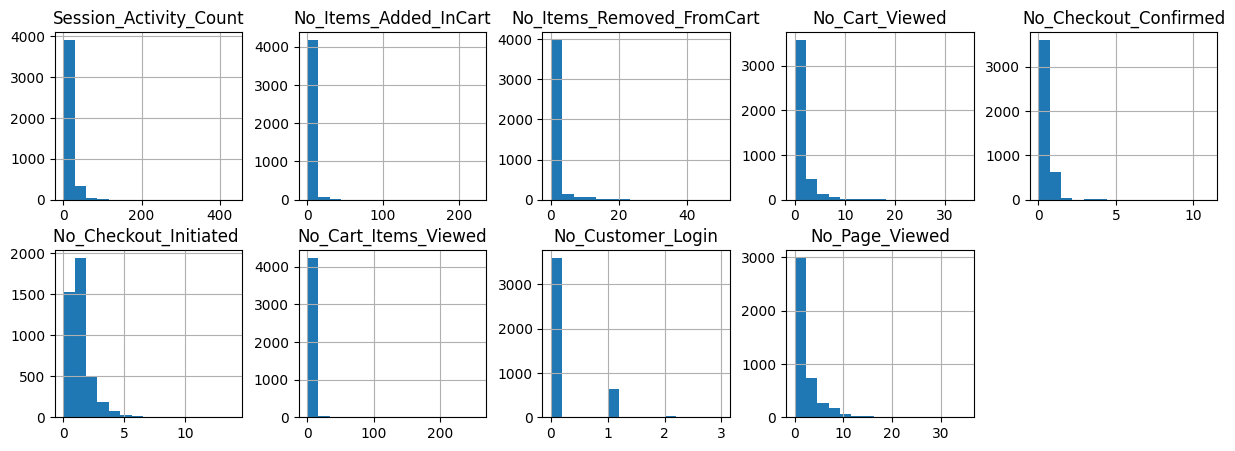

In [200]:
num=dataset.select_dtypes(include=["float64","int64"])
cat=dataset.select_dtypes(include=["object","category"]).drop(["ID"],axis=1)
num.hist(bins=15, figsize=(15, 5), layout=(2, 5));


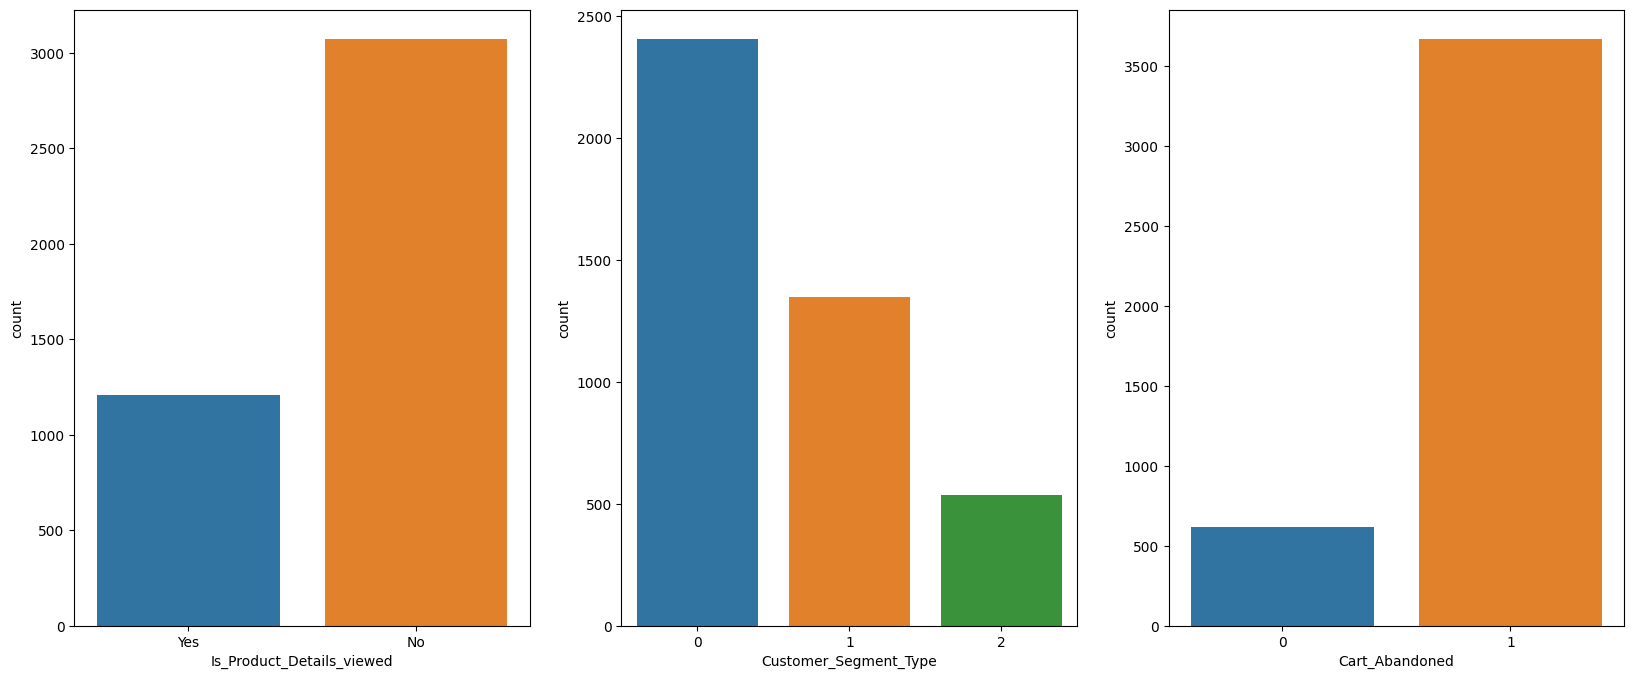

In [201]:
f, ax = plt.subplots(nrows=1,ncols=3,figsize=(20, 8))
for i,j in zip(cat.columns.tolist(), ax.flatten()):
    sns.countplot(x=cat[i],ax=j)

<Axes: xlabel='Is_Product_Details_viewed', ylabel='count'>

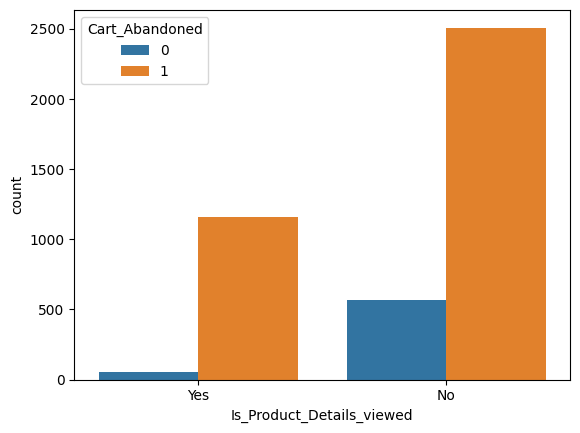

In [202]:
sns.countplot(x=dataset.Is_Product_Details_viewed,hue=dataset.Cart_Abandoned)

In [203]:
labels=dataset.loc[:,'No_Checkout_Confirmed'].values

for i in range(labels.shape[0]):
    if (labels[labels==int(i)].shape[0]!=0):
        print("No_Checkout_Confirmed ="+str(i) + " "  + str(labels[labels==int(i)].shape[0]))

No_Checkout_Confirmed =0 3597
No_Checkout_Confirmed =1 624
No_Checkout_Confirmed =2 42
No_Checkout_Confirmed =3 9
No_Checkout_Confirmed =4 5
No_Checkout_Confirmed =5 3
No_Checkout_Confirmed =6 1
No_Checkout_Confirmed =7 1
No_Checkout_Confirmed =8 1
No_Checkout_Confirmed =11 1


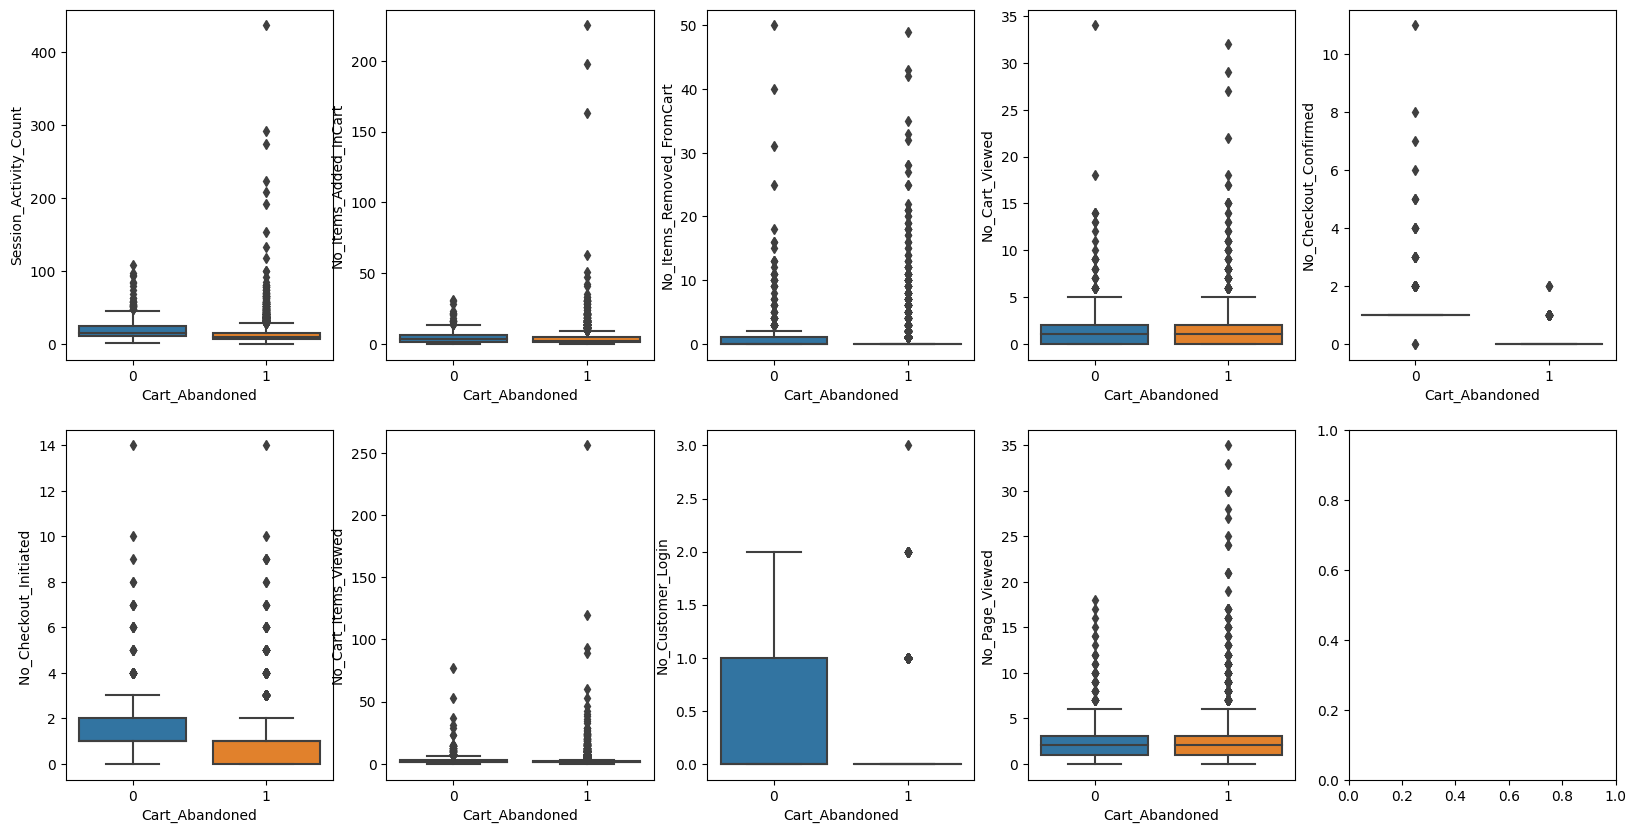

In [204]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for var, subplot in zip(num.columns.tolist(), ax.flatten()):
    sns.boxplot(x=cat["Cart_Abandoned"], y=num[var], ax=subplot)

<Axes: >

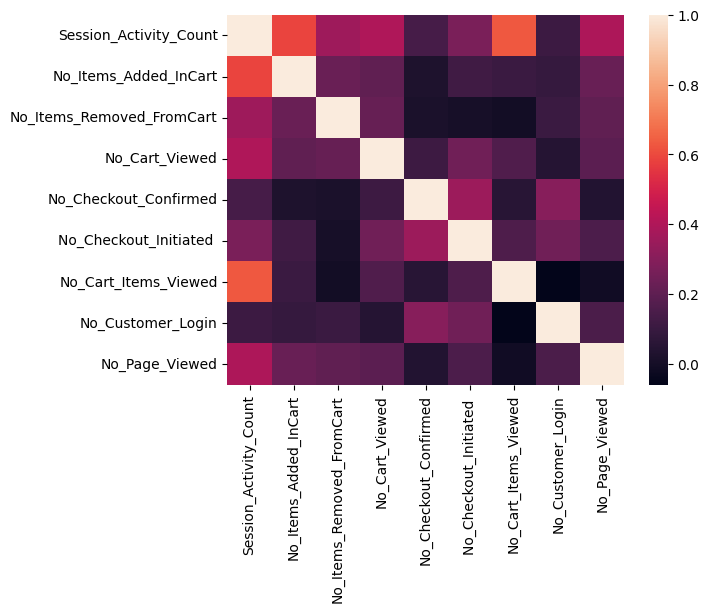

In [205]:
corrs = num.corr()
sns.heatmap(corrs)

In [206]:
data = dataset.copy()
# Create a summary of the missing values in the "data" dataset.
data.isna().sum()

ID                           0
Is_Product_Details_viewed    0
Session_Activity_Count       0
No_Items_Added_InCart        9
No_Items_Removed_FromCart    0
No_Cart_Viewed               9
No_Checkout_Confirmed        0
No_Checkout_Initiated        0
No_Cart_Items_Viewed         0
No_Customer_Login            0
No_Page_Viewed               0
Customer_Segment_Type        0
Cart_Abandoned               0
dtype: int64

In [207]:
# This way you can display all rows that have blank values in the "No_Items_Added_InCart" column.
print(data[data["No_Items_Added_InCart"].isna()])

               ID Is_Product_Details_viewed  Session_Activity_Count   
11  Session_ID_11                        No                       8  \
12  Session_ID_12                        No                       9   
13  Session_ID_13                       Yes                       8   
14  Session_ID_14                        No                       3   
15  Session_ID_15                        No                      31   
16  Session_ID_16                       Yes                       6   
17  Session_ID_17                       Yes                       7   
18  Session_ID_18                        No                      35   
19  Session_ID_19                        No                       8   

    No_Items_Added_InCart  No_Items_Removed_FromCart  No_Cart_Viewed   
11                    NaN                          0             NaN  \
12                    NaN                          0             NaN   
13                    NaN                          0             NaN   
1

In [208]:
# The list named null_col will contain the names of the columns in the dataset "data" that have at least one missing value.
null_col = data.columns[data.isna().any()].tolist()
null_col

['No_Items_Added_InCart', 'No_Cart_Viewed']

In [209]:

# Fill in the missing values in the column named "No_Items_Added_InCart" and "No_Cart_Viewed" in the dataset "data" with the average value.
data['No_Items_Added_InCart'] = data['No_Items_Added_InCart'].fillna(data['No_Items_Added_InCart'].mean()) 
data['No_Cart_Viewed'] = data['No_Cart_Viewed'].fillna(data['No_Cart_Viewed'].mean())


In [210]:
# Set the datatypes of the ['No_Items_Added_InCart', 'No_Cart_Viewed'] columns to "int64".
data[null_col] = data[null_col].astype("int64")

In [211]:
# data type check
data.dtypes

ID                             object
Is_Product_Details_viewed      object
Session_Activity_Count          int64
No_Items_Added_InCart           int64
No_Items_Removed_FromCart       int64
No_Cart_Viewed                  int64
No_Checkout_Confirmed           int64
No_Checkout_Initiated           int64
No_Cart_Items_Viewed            int64
No_Customer_Login               int64
No_Page_Viewed                  int64
Customer_Segment_Type        category
Cart_Abandoned               category
dtype: object

In [212]:
# missing value check
data.isna().sum()

ID                           0
Is_Product_Details_viewed    0
Session_Activity_Count       0
No_Items_Added_InCart        0
No_Items_Removed_FromCart    0
No_Cart_Viewed               0
No_Checkout_Confirmed        0
No_Checkout_Initiated        0
No_Cart_Items_Viewed         0
No_Customer_Login            0
No_Page_Viewed               0
Customer_Segment_Type        0
Cart_Abandoned               0
dtype: int64

In [213]:
data.head(5)

,ID,Is_Product_Details_viewed,Session_Activity_Count,No_Items_Added_InCart,No_Items_Removed_FromCart,No_Cart_Viewed,No_Checkout_Confirmed,No_Checkout_Initiated,No_Cart_Items_Viewed,No_Customer_Login,No_Page_Viewed,Customer_Segment_Type,Cart_Abandoned
0,Session_ID_0,Yes,4,1,0,0,0,0,1,0,0,0,1
1,Session_ID_1,No,38,0,0,2,0,0,2,0,2,0,1
2,Session_ID_2,No,8,5,0,0,1,1,1,0,0,1,0
3,Session_ID_3,No,6,0,0,2,0,0,4,0,0,0,1
4,Session_ID_4,Yes,31,14,12,1,0,0,4,0,0,2,1


In [214]:
# The "num" dataframe contains columns with numeric values in the "data" dataset.
# The "cat" data frame contains columns with textual or categorical values. The "ID" column has been omitted from the "cat" dataframe.
num=data.select_dtypes(include=["int64"])
cat=data.select_dtypes(include=["object","category"]).drop(["ID"],axis=1)

In [215]:
# A scaled version of the numeric values in the "num" dataset is assigned to the variable "x_scaled".
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(num)

In [216]:
# The pd.DataFrame() function is used to convert data to DataFrame format.
# The "x_scaled" scaled data is used as the data to form the content of this DataFrame.
# The "columns=num.columns" parameter sets the column names to the column names in the num dataset.
# Thus, the columns in the scaled DataFrame retain the names of the columns of the original "num" DataFrame.
df_scaled = pd.DataFrame(x_scaled,columns=num.columns)
df_scaled.head(5)

,Session_Activity_Count,No_Items_Added_InCart,No_Items_Removed_FromCart,No_Cart_Viewed,No_Checkout_Confirmed,No_Checkout_Initiated,No_Cart_Items_Viewed,No_Customer_Login,No_Page_Viewed
0,0.009174,0.004444,0.00,0.000000,0.000000,0.000000,0.003906,0.0,0.000000
1,0.087156,0.000000,0.00,0.058824,0.000000,0.000000,0.007812,0.0,0.057143
2,0.018349,0.022222,0.00,0.000000,0.090909,0.071429,0.003906,0.0,0.000000
3,0.013761,0.000000,0.00,0.058824,0.000000,0.000000,0.015625,0.0,0.000000
4,0.071101,0.062222,0.24,0.029412,0.000000,0.000000,0.015625,0.0,0.000000


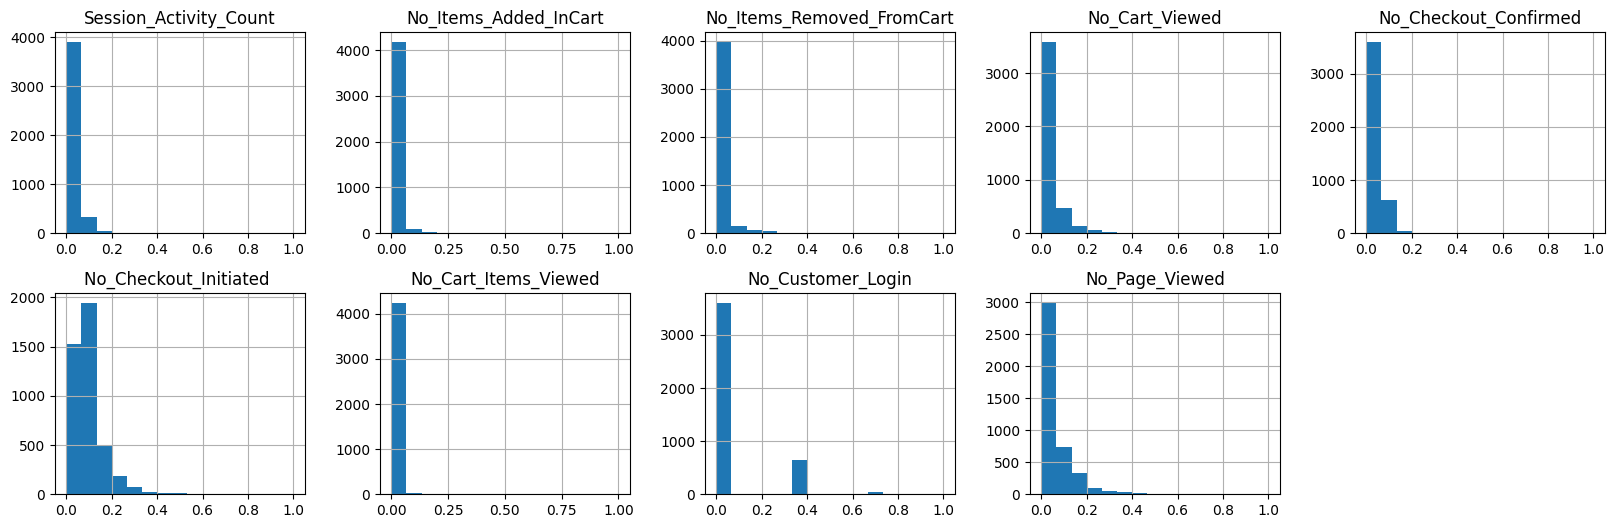

In [217]:
df_scaled.hist(bins=15, figsize=(20, 6), layout=(2, 5));

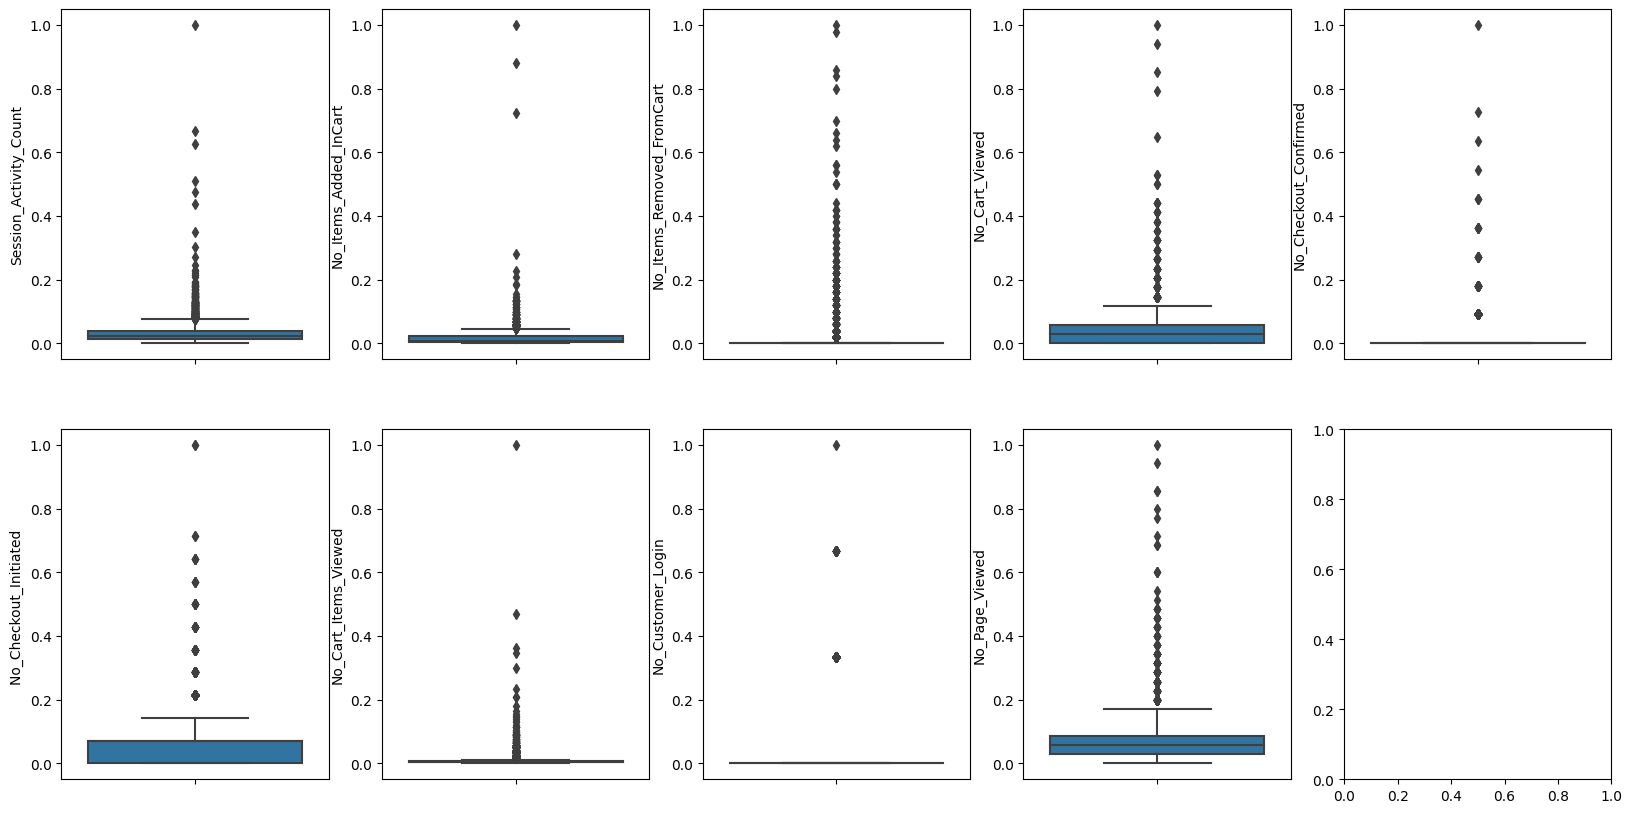

In [218]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for var, subplot in zip(df_scaled.columns.tolist(), ax.flatten()):
    sns.boxplot(y=df_scaled[var], ax=subplot)

Box-Cox normalization is a data transformation technique used to approximate the data distribution to a more normal distribution. The normalization process aims to make the data more symmetric and homogeneous by applying a transformation to the data.

Box-Cox normalization is commonly used, particularly in models such as regression analysis, to satisfy the assumption of normal distribution in the data. The assumption of normal distribution is important for various statistical methods and tests to work accurately.

Box-Cox normalization can be applied to data with positive values or values different from zero. The Box-Cox transformation normalizes the data by applying a specific parameter to each data point. This parameter controls the shape of the transformation, and when the transformation parameter is zero, it corresponds to a logarithmic transformation.

The Box-Cox transformation can be expressed with the following formula:

y(lambda) = [(x^lambda) - 1] / lambda

Where:

y(lambda): Transformed data
x: Original data
lambda: Transformation parameter
In Box-Cox transformation, different lambda values can be used, which determine the shape of the transformation. For example, a lambda value of 0 corresponds to a logarithmic transformation, a lambda value of 1 corresponds to a linear transformation, and a lambda value of 0.5 corresponds to a square root transformation.

Box-Cox normalization is a commonly used method to approximate data to a normal distribution. However, there are certain considerations and limitations that need to be carefully evaluated during the transformation process. Particularly, when the data has values close to zero or negative values, applying Box-Cox normalization can be challenging. Additionally, different transformation methods may be preferred based on the characteristics of the data and the purpose of the analysis.

In [219]:
df_scaled_boxcox=boxcox1p(num, 0)

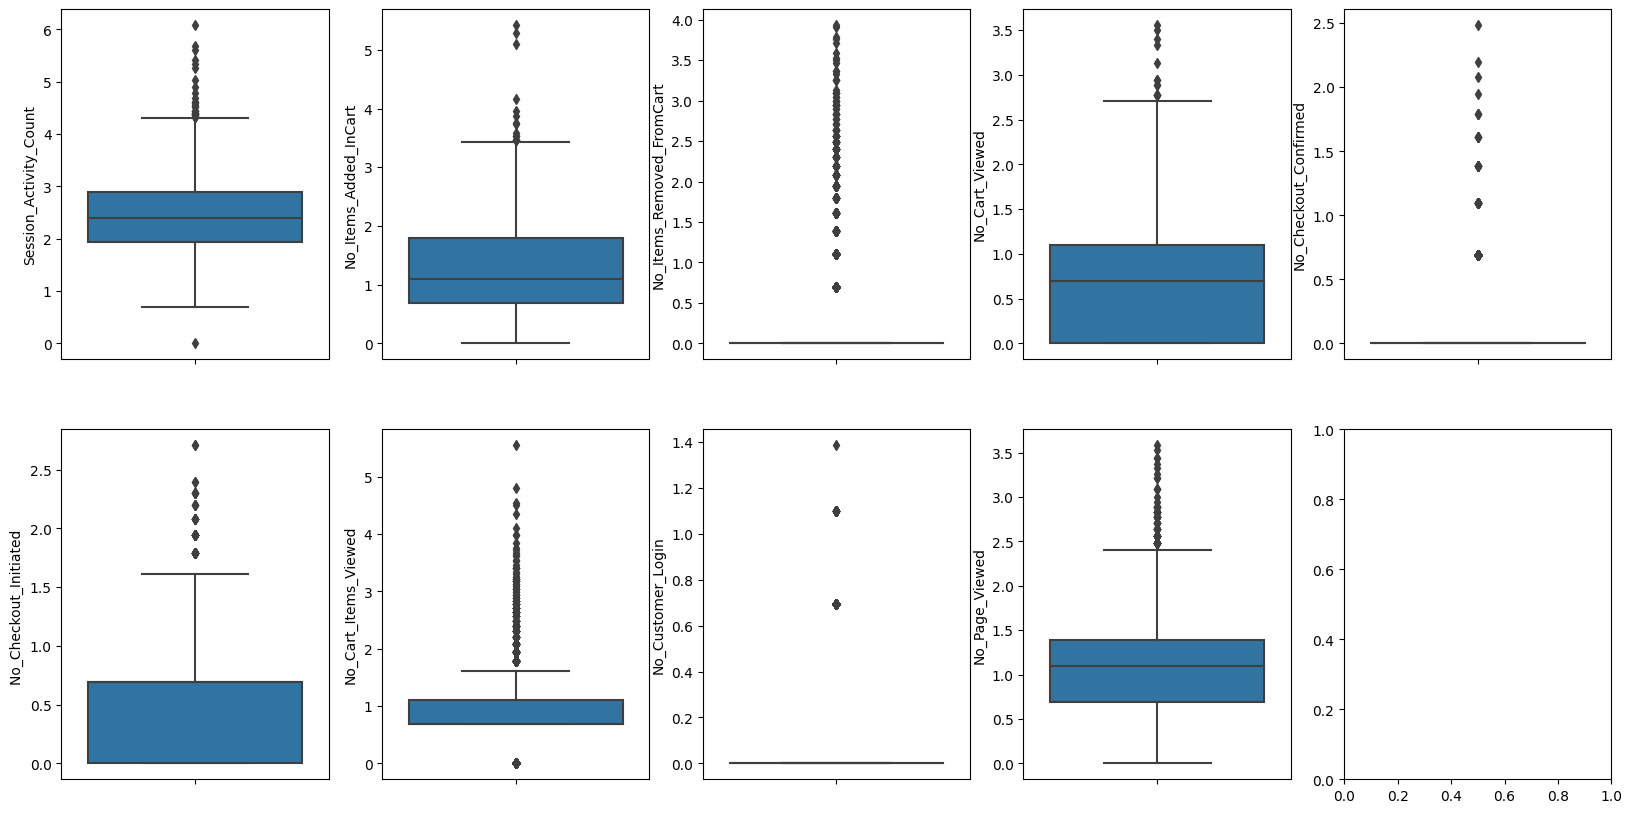

In [220]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for var, subplot in zip(df_scaled_boxcox.columns.tolist(), ax.flatten()):
    sns.boxplot(y=df_scaled_boxcox[var], ax=subplot)

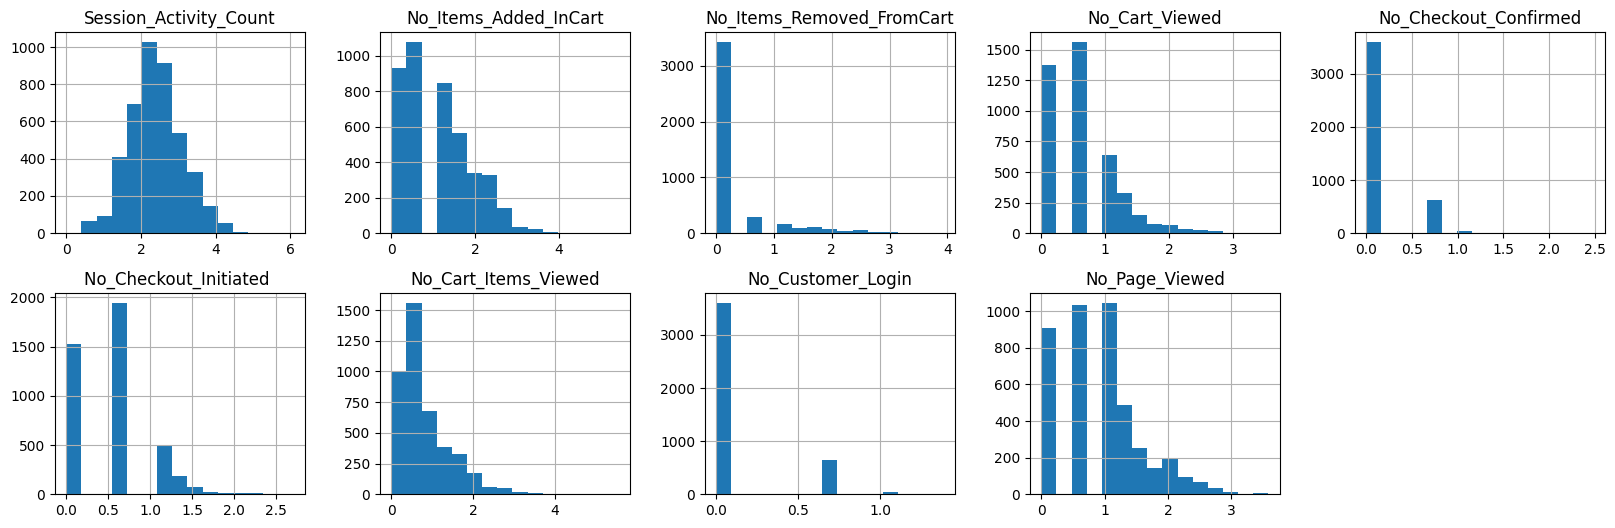

In [221]:
df_scaled_boxcox.hist(bins=15, figsize=(20, 6), layout=(2, 5));

In [222]:
df_scaled_boxcox.head(5)

,Session_Activity_Count,No_Items_Added_InCart,No_Items_Removed_FromCart,No_Cart_Viewed,No_Checkout_Confirmed,No_Checkout_Initiated,No_Cart_Items_Viewed,No_Customer_Login,No_Page_Viewed
0,1.609438,0.693147,0.000000,0.000000,0.000000,0.000000,0.693147,0.0,0.000000
1,3.663562,0.000000,0.000000,1.098612,0.000000,0.000000,1.098612,0.0,1.098612
2,2.197225,1.791759,0.000000,0.000000,0.693147,0.693147,0.693147,0.0,0.000000
3,1.945910,0.000000,0.000000,1.098612,0.000000,0.000000,1.609438,0.0,0.000000
4,3.465736,2.708050,2.564949,0.693147,0.000000,0.000000,1.609438,0.0,0.000000


In [223]:
# The 'df_scaled_boxcox' DataFrame will have a column containing the 'ID' column and the 'ID' column is set as the DataFrame's index.
# In this way, the 'ID' column becomes an index used to access data.
df_scaled_boxcox["ID"]=data.ID
df_scaled_boxcox.set_index('ID',inplace=True)
df_scaled_boxcox.reset_index(inplace=True)
df_scaled_boxcox

,ID,Session_Activity_Count,No_Items_Added_InCart,No_Items_Removed_FromCart,No_Cart_Viewed,No_Checkout_Confirmed,No_Checkout_Initiated,No_Cart_Items_Viewed,No_Customer_Login,No_Page_Viewed
0,Session_ID_0,1.609438,0.693147,0.000000,0.000000,0.000000,0.000000,0.693147,0.0,0.000000
1,Session_ID_1,3.663562,0.000000,0.000000,1.098612,0.000000,0.000000,1.098612,0.0,1.098612
2,Session_ID_2,2.197225,1.791759,0.000000,0.000000,0.693147,0.693147,0.693147,0.0,0.000000
3,Session_ID_3,1.945910,0.000000,0.000000,1.098612,0.000000,0.000000,1.609438,0.0,0.000000
4,Session_ID_4,3.465736,2.708050,2.564949,0.693147,0.000000,0.000000,1.609438,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
4279,Session_ID_4279,3.178054,1.791759,1.945910,1.098612,0.000000,0.000000,1.386294,0.0,2.079442
4280,Session_ID_4280,2.079442,1.098612,0.000000,1.386294,0.000000,0.000000,0.693147,0.0,0.000000
4281,Session_ID_4281,1.609438,0.693147,0.000000,0.693147,0.000000,0.693147,0.693147,0.0,0.000000
4282,Session_ID_4282,2.197225,1.386294,0.000000,0.693147,0.000000,0.693147,0.693147,0.0,1.098612


In [224]:
# The 'df_scaled_boxcox' DataFrame is combined with the 'cat' DataFrame.
# The 'join()' method is used to join two DataFrames.
# This operation combines the data by matching on the 'ID' column.
df_final=df_scaled_boxcox.join(cat)
df_final.head(5)

,ID,Session_Activity_Count,No_Items_Added_InCart,No_Items_Removed_FromCart,No_Cart_Viewed,No_Checkout_Confirmed,No_Checkout_Initiated,No_Cart_Items_Viewed,No_Customer_Login,No_Page_Viewed,Is_Product_Details_viewed,Customer_Segment_Type,Cart_Abandoned
0,Session_ID_0,1.609438,0.693147,0.000000,0.000000,0.000000,0.000000,0.693147,0.0,0.000000,Yes,0,1
1,Session_ID_1,3.663562,0.000000,0.000000,1.098612,0.000000,0.000000,1.098612,0.0,1.098612,No,0,1
2,Session_ID_2,2.197225,1.791759,0.000000,0.000000,0.693147,0.693147,0.693147,0.0,0.000000,No,1,0
3,Session_ID_3,1.945910,0.000000,0.000000,1.098612,0.000000,0.000000,1.609438,0.0,0.000000,No,0,1
4,Session_ID_4,3.465736,2.708050,2.564949,0.693147,0.000000,0.000000,1.609438,0.0,0.000000,Yes,2,1


In [225]:
# The 'Yes' and 'No' values in the 'Is_Product_Details_viewed' column of the 'df_final' DataFrame are replaced with 1 and 0 respectively.
# This can convert categorical values to numeric values, making it easier to process or analyze data.
df_final.Is_Product_Details_viewed.replace({"Yes":1,"No":0},inplace=True)
df_final.head(5)

,ID,Session_Activity_Count,No_Items_Added_InCart,No_Items_Removed_FromCart,No_Cart_Viewed,No_Checkout_Confirmed,No_Checkout_Initiated,No_Cart_Items_Viewed,No_Customer_Login,No_Page_Viewed,Is_Product_Details_viewed,Customer_Segment_Type,Cart_Abandoned
0,Session_ID_0,1.609438,0.693147,0.000000,0.000000,0.000000,0.000000,0.693147,0.0,0.000000,1,0,1
1,Session_ID_1,3.663562,0.000000,0.000000,1.098612,0.000000,0.000000,1.098612,0.0,1.098612,0,0,1
2,Session_ID_2,2.197225,1.791759,0.000000,0.000000,0.693147,0.693147,0.693147,0.0,0.000000,0,1,0
3,Session_ID_3,1.945910,0.000000,0.000000,1.098612,0.000000,0.000000,1.609438,0.0,0.000000,0,0,1
4,Session_ID_4,3.465736,2.708050,2.564949,0.693147,0.000000,0.000000,1.609438,0.0,0.000000,1,2,1


In [226]:
df_final.dtypes

ID                             object
Session_Activity_Count        float64
No_Items_Added_InCart         float64
No_Items_Removed_FromCart     float64
No_Cart_Viewed                float64
No_Checkout_Confirmed         float64
No_Checkout_Initiated         float64
No_Cart_Items_Viewed          float64
No_Customer_Login             float64
No_Page_Viewed                float64
Is_Product_Details_viewed       int64
Customer_Segment_Type        category
Cart_Abandoned               category
dtype: object

In [227]:
# Converts column "Is_Product_Details_viewed" of DataFrame named "df_final" to a categorical variable.
df_final.Is_Product_Details_viewed=pd.Categorical(df_final.Is_Product_Details_viewed)
df_final.dtypes

ID                             object
Session_Activity_Count        float64
No_Items_Added_InCart         float64
No_Items_Removed_FromCart     float64
No_Cart_Viewed                float64
No_Checkout_Confirmed         float64
No_Checkout_Initiated         float64
No_Cart_Items_Viewed          float64
No_Customer_Login             float64
No_Page_Viewed                float64
Is_Product_Details_viewed    category
Customer_Segment_Type        category
Cart_Abandoned               category
dtype: object

In [228]:
# A new DataFrame named "X" is created by selecting columns from column 1 to column 12 in the DataFrame named "df_final". (to exclude the "Cart_Abandoned" column)
X=df_final.iloc[:,1:12]
y=df_final["Cart_Abandoned"]

RFE stands for Recursive Feature Elimination, which is a method used for feature selection. In this method, a machine learning model (typically a classification or regression model) is employed to evaluate the importance of features. Initially, all features are used, and sequentially, the least important features are eliminated. The importance of features is assessed based on the backward elimination error obtained from the model. This process continues until a specified number or a threshold of importance is reached, and the top features are selected. RFE is a feature selection method used to improve model performance, reduce overfitting, and reduce data dimensionality.

In [229]:
# It performs the Recursive Feature Elimination (RFE) method by using the Logistic Regression algorithm. The best 7 features are selected.
lr = LogisticRegression()
lr.fit(X,y)
rfe = RFE(lr, n_features_to_select=7, verbose = 3 )
fit=rfe.fit(X,y)
selected = fit.support_

for i,x in enumerate(fit.support_):
    if x == True:
        print(f"Selected Features : {X.columns[i]} \nFeature Ranking : {fit.ranking_[i]}\n")

Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Selected Features : Session_Activity_Count 
Feature Ranking : 1

Selected Features : No_Cart_Viewed 
Feature Ranking : 1

Selected Features : No_Checkout_Confirmed 
Feature Ranking : 1

Selected Features : No_Checkout_Initiated  
Feature Ranking : 1

Selected Features : No_Customer_Login 
Feature Ranking : 1

Selected Features : No_Page_Viewed 
Feature Ranking : 1

Selected Features : Is_Product_Details_viewed 
Feature Ranking : 1



In [230]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X, y)
feature_weightage_dict = dict()
# Print the name and gini importance of each feature
for feature in zip(X.columns, clf.feature_importances_):
    feature_weightage_dict.update({feature[0]:feature[1]})

In [231]:
feature_weightage_dict

{'Session_Activity_Count': 0.05052857005529642,
 'No_Items_Added_InCart': 0.025547984898027527,
 'No_Items_Removed_FromCart': 0.010172300692196705,
 'No_Cart_Viewed': 0.017810335296951977,
 'No_Checkout_Confirmed': 0.7341868777064404,
 'No_Checkout_Initiated ': 0.0441808380652188,
 'No_Cart_Items_Viewed': 0.018703955749515146,
 'No_Customer_Login': 0.05604221107820115,
 'No_Page_Viewed': 0.027120211503535017,
 'Is_Product_Details_viewed': 0.009764913736069736,
 'Customer_Segment_Type': 0.0059418012185472185}

In [232]:
sorted_feature_weightage_dict = sorted(feature_weightage_dict.items(), key=lambda kv: kv[1], reverse = True)
sorted_feature_weightage_dict

[('No_Checkout_Confirmed', 0.7341868777064404),
 ('No_Customer_Login', 0.05604221107820115),
 ('Session_Activity_Count', 0.05052857005529642),
 ('No_Checkout_Initiated ', 0.0441808380652188),
 ('No_Page_Viewed', 0.027120211503535017),
 ('No_Items_Added_InCart', 0.025547984898027527),
 ('No_Cart_Items_Viewed', 0.018703955749515146),
 ('No_Cart_Viewed', 0.017810335296951977),
 ('No_Items_Removed_FromCart', 0.010172300692196705),
 ('Is_Product_Details_viewed', 0.009764913736069736),
 ('Customer_Segment_Type', 0.0059418012185472185)]

In [233]:
df_final.columns

Index(['ID', 'Session_Activity_Count', 'No_Items_Added_InCart',
       'No_Items_Removed_FromCart', 'No_Cart_Viewed', 'No_Checkout_Confirmed',
       'No_Checkout_Initiated ', 'No_Cart_Items_Viewed', 'No_Customer_Login',
       'No_Page_Viewed', 'Is_Product_Details_viewed', 'Customer_Segment_Type',
       'Cart_Abandoned'],
      dtype='object')

What are the important factors related to cart abandonment?

Now comparing both the models we can see the Session_Activity_Count, No_Checkout_Confirmed, No_Checkout_Initiated, No_Customer_Login and No_Page_Viewed has the higher feature importance. So we will only consider these features to train our model.

In [234]:
tab=[5,6,8,9,1]
for item in tab:
    print(df_final[df_final.columns[item]].name)

No_Checkout_Confirmed
No_Checkout_Initiated 
No_Customer_Login
No_Page_Viewed
Session_Activity_Count


In [235]:
X = df_final.iloc[:,[5,6,8,9,1]]
y = df_final.loc[:,["Cart_Abandoned"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=0)

By using the SMOTE method, the minority class samples are replicated and the training dataset is balanced. This aims at better representation of minority class samples and improved classification performance.

In [236]:
sm = SMOTE(random_state=2,k_neighbors=5)
X_train, y_train =sm.fit_resample(X_train,y_train)

In [237]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_train, y_train, test_size=0.40, random_state=0)

In [238]:
lr1 = LogisticRegression()
lr1.fit(X_train_new,y_train_new)

y_pred_new = lr1.predict(X_test_new)  #### For SMOTE validation samples
y_pred=lr1.predict(X_test)##### For actual validation samples

c:\Users\AVCI\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [239]:
print("First Predict Score")
print(" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(" Kappa is %f" %cohen_kappa_score(y_test, y_pred))
print("\nSecond Predict Score")
print(" accuracy is %2.3f" % accuracy_score(y_test_new, y_pred_new))
print(" Kappa is %f" %cohen_kappa_score(y_test_new, y_pred_new))

First Predict Score
 accuracy is 0.984
 Kappa is 0.936154

Second Predict Score
 accuracy is 0.988
 Kappa is 0.976122


In [240]:
sat=lr1.predict(X_test)


In [241]:
with open("predict.txt", "w") as dosya:
    for eleman in sat:
        dosya.write(str(eleman) + "\n")